# Stock Correlation

- In this notebook we will explore the clustering of stocks using correlation between the stock prices of different companies. Our aim is to see is the reulsting clusters actullay map out to NIFTY sectors. We shall use NIFTY 150 stocks for this purpose.  We will use Stochastic Block Model to cluster the stocks based on their correlation. 


- We shall use the following steps to cluster the stocks:
    1. Get the stock data for NIFTY 150 stocks.
    2. Calculate the correlation matrix.
    3. Construct a weighted undirected graph.
    4. Cluster the stocks using Stochastic Block Model.
    5. Visualize the correlation matrix.
    6. Visualize the clustering of the stocks.
    7. Compare it to the NIFTY sectors.
    8. Also see the greedy modularity based cluserting. 

- We have used a tmie perdiod of 5 years for the stock data with an interval of 5 days to better capture the correlation between the stocks.

- We have used a log transformation of the stock prices to better capture the correlation between the stocks.





In [1]:
! pip install -q yfinance pandas numpy networkx matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm  
import seaborn as sns
import graph_tool.all as gt
import os

## Preprocess the data

We shall take the stock prices of NIFTY 150 stocks. We shall then calculate the daily returns of the stocks and then calculate the correlation between the stocks based on the daily returns.

**Valid time intervals in yfinance are**: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo

**Valide periods are**: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

Using small intervals will not capture the correlation between the stocks since these are just fluctuations in the stock prices. We founf that using 5d intervals gives a good correlation between the stocks.

In [3]:
def get_nifty150_tickers():
    """Get NIFTY 150 tickers"""
    nifty150_tickers = [
        "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS",
        "HINDUNILVR.NS", "ITC.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS",
        "HCLTECH.NS", "LT.NS", "AXISBANK.NS", "ASIANPAINT.NS", "MARUTI.NS",
        "SUNPHARMA.NS", "TITAN.NS", "ULTRACEMCO.NS", "WIPRO.NS", "NESTLEIND.NS",
        "M&M.NS", "BAJFINANCE.NS", "POWERGRID.NS", "ONGC.NS", "NTPC.NS",
        "SBILIFE.NS", "BAJAJFINSV.NS", "ADANIGREEN.NS", "ADANIPORTS.NS", "ADANIENT.NS",
        "DIVISLAB.NS", "GRASIM.NS", "JSWSTEEL.NS", "TATAMOTORS.NS", "TECHM.NS",
        "HDFCLIFE.NS", "COALINDIA.NS", "BPCL.NS", "BRITANNIA.NS", "SHREECEM.NS",
        "HEROMOTOCO.NS", "CIPLA.NS", "DRREDDY.NS", "EICHERMOT.NS", "BAJAJ-AUTO.NS",
        "INDUSINDBK.NS", "TATACONSUM.NS", "VEDL.NS", "DABUR.NS", "HAVELLS.NS",
        "ICICIPRULI.NS", "PIDILITIND.NS", "SBICARD.NS", "SIEMENS.NS", "GODREJCP.NS",
        "DLF.NS", "HINDALCO.NS", "TATAPOWER.NS", "AMBUJACEM.NS",
        "APOLLOHOSP.NS", "AUROPHARMA.NS", "BANDHANBNK.NS", "BERGEPAINT.NS", "BIOCON.NS",
        "BOSCHLTD.NS", "CHOLAFIN.NS", "COLPAL.NS", "DABUR.NS",
        "GAIL.NS", "GLAND.NS", "GODREJPROP.NS", "HDFCAMC.NS", "ICICIGI.NS",
        "IGL.NS", "INDIGO.NS", "LUPIN.NS", "M&MFIN.NS", "MARICO.NS",
        "MUTHOOTFIN.NS", "NAUKRI.NS", "PEL.NS", "PGHH.NS", "PFC.NS",
        "RECLTD.NS", "SAIL.NS", "SRF.NS", "TATACHEM.NS", "TORNTPHARM.NS",
        "TVSMOTOR.NS", "UBL.NS", "UPL.NS", "VOLTAS.NS", "WHIRLPOOL.NS",
        "ZEEL.NS", "ZYDUSLIFE.NS", "ABB.NS", "ACC.NS",
        "ALKEM.NS", "APOLLOTYRE.NS", "ASHOKLEY.NS", "BANKBARODA.NS",
        "BHARATFORG.NS", "BHEL.NS", "CANBK.NS", "CASTROLIND.NS", "CROMPTON.NS",
        "CUMMINSIND.NS", "DALBHARAT.NS", "DEEPAKNTR.NS", "ESCORTS.NS", "EXIDEIND.NS",
        "FEDERALBNK.NS", "GLENMARK.NS", "GMRINFRA.NS", "GODREJAGRO.NS", "GRANULES.NS",
        "GUJGASLTD.NS", "HAL.NS", "HINDPETRO.NS", "HINDZINC.NS", "IDEA.NS",
        "IDFCFIRSTB.NS", "INDHOTEL.NS", "INDUSTOWER.NS", "IPCALAB.NS", "JINDALSTEL.NS",
        "JSWENERGY.NS", "LICHSGFIN.NS", "LTTS.NS", "MANAPPURAM.NS",
        "MFSL.NS", "MGL.NS", "MPHASIS.NS",
        "MRF.NS", "NAM-INDIA.NS", "NAVINFLUOR.NS", "NMDC.NS", "PAGEIND.NS",
        "PFIZER.NS", "PIIND.NS", "PNB.NS", "POLYCAB.NS",
        "RAMCOCEM.NS", "RBLBANK.NS", "SHREECEM.NS", "SUNTV.NS",
        "SYNGENE.NS", "TATACOMM.NS", "TATAELXSI.NS", "TORNTPOWER.NS", "TRENT.NS",
        "UNIONBANK.NS", "VBL.NS", "TORNTPHARM.NS", "WHIRLPOOL.NS", "ZEEL.NS"
    ]
    return nifty150_tickers

def fetch_stock_data(tickers, period, interval):
    """
    Fetch stock data for given tickers with specified period and interval
    
    Parameters:
    -----------
    tickers : list
        List of stock tickers
    period : str
        Time period to fetch (e.g., '5y' for 5 years)
    interval : str
        Data interval (e.g., '5d' for 5 days)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with closing prices for all stocks
    """
    print(f"Fetching {len(tickers)} stocks for period: {period}, interval: {interval}")
    
    data_list = []
    valid_tickers = []
    failed_tickers = []
    
    # Create progress bar
    for ticker in tqdm(tickers, desc="Fetching stocks"):
        try:
            # Fetch data with retry mechanism
            retries = 3
            for attempt in range(retries):
                try:
                    stock = yf.Ticker(ticker)
                    hist = stock.history(period=period, interval=interval)['Close']
                    
                    # Check if we got enough data
                    if len(hist) < 10:  # Minimum required data points
                        raise ValueError(f"Insufficient data points ({len(hist)}) for {ticker}")
                    
                    # Check for too many missing values
                    missing_pct = hist.isna().mean() * 100
                    if missing_pct > 20:  # More than 20% missing
                        raise ValueError(f"Too many missing values ({missing_pct:.1f}%) for {ticker}")
                    
                    # Forward fill missing values
                    hist = hist.ffill()
                    
                    data_list.append(hist)
                    valid_tickers.append(ticker)
                    break
                    
                except Exception as e:
                    if attempt == retries - 1:  # Last attempt
                        raise e
                    continue
                    
        except Exception as e:
            failed_tickers.append((ticker, str(e)))
            print(f"\nWarning: Failed to fetch {ticker}: {str(e)}")
    
    if not data_list:
        raise ValueError("No valid data fetched for any ticker")
    
    # Combine all data
    data = pd.concat(data_list, axis=1)
    data.columns = valid_tickers
    
    # Print summary
    print(f"\nData Summary:")
    print(f"Successfully fetched: {len(valid_tickers)} stocks")
    print(f"Failed to fetch: {len(failed_tickers)} stocks")
    print(f"Date range: {data.index[0]} to {data.index[-1]}")
    print(f"Total intervals: {len(data)}")
    
    # Save failed tickers for reference
    if failed_tickers:
        pd.DataFrame(failed_tickers, columns=['Ticker', 'Error']).to_csv('failed_tickers.csv', index=False)
    
    # Basic data validation
    missing_data = data.isna().sum()
    if missing_data.any():
        print("\nWarning: Missing data detected:")
        print(missing_data[missing_data > 0])
        
        # Forward fill remaining missing values
        data = data.ffill()
        
    return data

def calculate_correlations(data, min_periods=None):
    """
    Calculate correlation matrix with minimum periods requirement
    
    Parameters:
    -----------
    data : pd.DataFrame
        Stock growth data
    min_periods : int, optional
        Minimum number of valid periods required to calculate correlation
    
    Returns:
    --------
    pd.DataFrame
        Correlation matrix
    list
        List of edges with correlation weights
    """
    
    # If min_periods not specified, use 20% of data length
    if min_periods is None:
        min_periods = int(len(data) * 0.2)
        
    # Calculate correlation matrix
    corr_matrix = data.corr(min_periods=min_periods)
    
    # Create edge list with correlations as weights
    edges = []
    for i in range(len(corr_matrix.index)):
        for j in range(i + 1, len(corr_matrix.columns)):
            stock1 = corr_matrix.index[i]
            stock2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            if pd.notnull(correlation):  # Only add valid correlations
                edges.append((stock1, stock2, abs(correlation)))
    
    return corr_matrix, edges

def create_correlation_graph(edges, min_correlation): # we can use a different threshold to map more strongly correlated stocks 
    """Create correlation network"""
    G = nx.Graph()
    
    # Add edges with weights, excluding self-loops
    for stock1, stock2, weight in edges:
        if stock1 != stock2 and weight >= min_correlation:
            G.add_edge(stock1, stock2, weight=weight)
    
    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))
    
    return G

In [4]:
# get nifty 150 tickers
tickers= get_nifty150_tickers()

if not os.path.exists('stocks'):
    os.makedirs('stocks')

print("Fetching Stock Data")
stock_data =  fetch_stock_data(tickers, period='5y', interval='5d')
stock_data.to_csv('./stocks/nifty150_prices.csv')

Fetching Stock Data
Fetching 156 stocks for period: 5y, interval: 5d


Fetching stocks: 100%|██████████| 156/156 [00:33<00:00,  4.63it/s]



Data Summary:
Successfully fetched: 156 stocks
Failed to fetch: 0 stocks
Date range: 2019-12-03 00:00:00+05:30 to 2024-12-03 00:00:00+05:30
Total intervals: 679

RELIANCE.NS      432
TCS.NS           432
HDFCBANK.NS      432
INFY.NS          432
ICICIBANK.NS     432
                ... 
UNIONBANK.NS     432
VBL.NS           432
TORNTPHARM.NS    432
WHIRLPOOL.NS     432
ZEEL.NS          432
Length: 156, dtype: int64


Since the Stochastic Block Model uses a weighted underlying graph, we shall use the correlation between stocks as the weight of the edges between the nodes.


Calculating stock growth (returns)...

Calculating correlations between stocks...


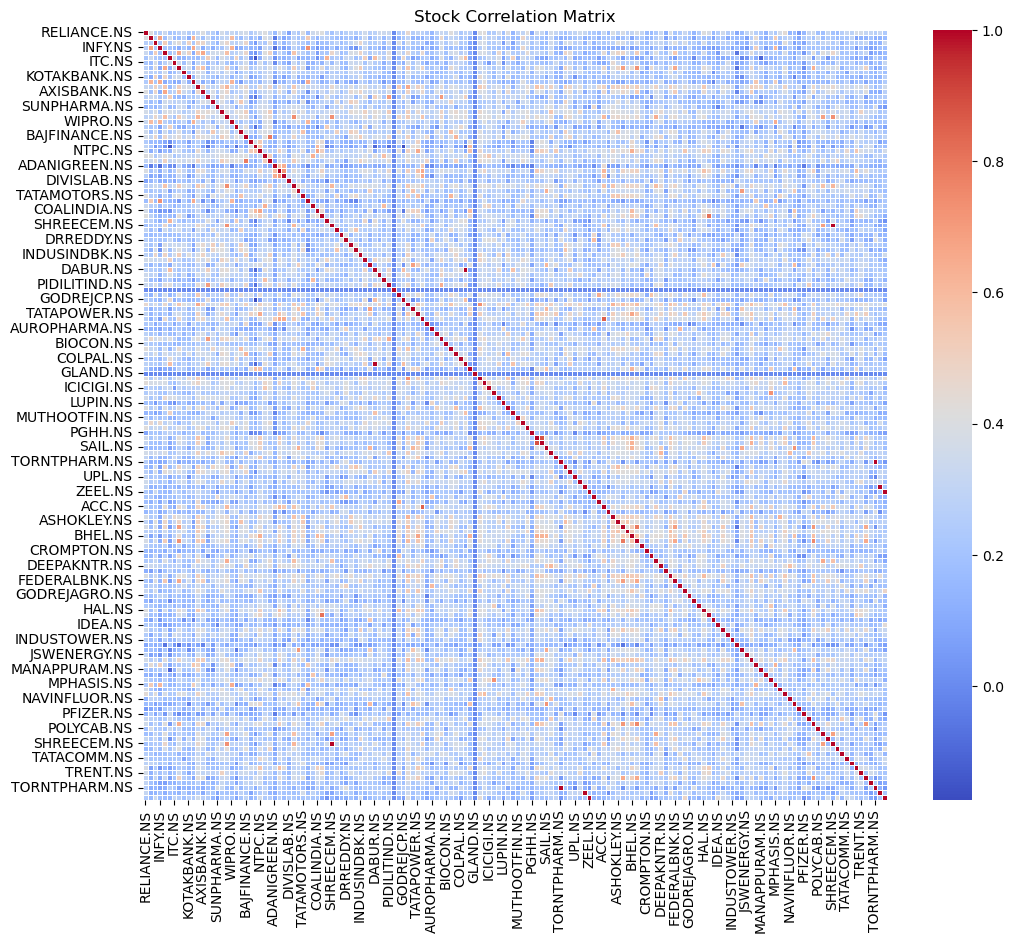

In [5]:
# Calculate stock growth (returns)
print("\nCalculating stock growth (returns)...")
# You can choose between simple percentage change or log returns
# Option 1: Simple Percentage Change
#stock_growth = stock_data.pct_change().dropna()

# Option 2: Log Returns (we preferred this as it additive and easier to aggregate returns over multiple periods)
stock_growth = np.log(stock_data / stock_data.shift(1)).dropna()

# Save stock growth data
stock_growth.to_csv('./stocks/nifty150_growth.csv')

# Calculate correlation matrix
print("\nCalculating correlations between stocks...")
corr_matrix, edges = calculate_correlations(stock_growth) #, min_periods=100


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Stock Correlation Matrix')
plt.show()

# Save correlation matrix to CSV
corr_matrix.to_csv('./stocks/nifty150_correlations.csv')

# Save edges list
edge_df = pd.DataFrame(edges, columns=['Stock1', 'Stock2', 'Correlation'])
edge_df.to_csv('./stocks/nifty150_edges.csv', index=False)

We cap minimum correlation at 0.45 to get meaningful clusters. 


Network Summary:
Number of nodes: 129
Number of edges: 655
Average clustering coefficient: 0.5293


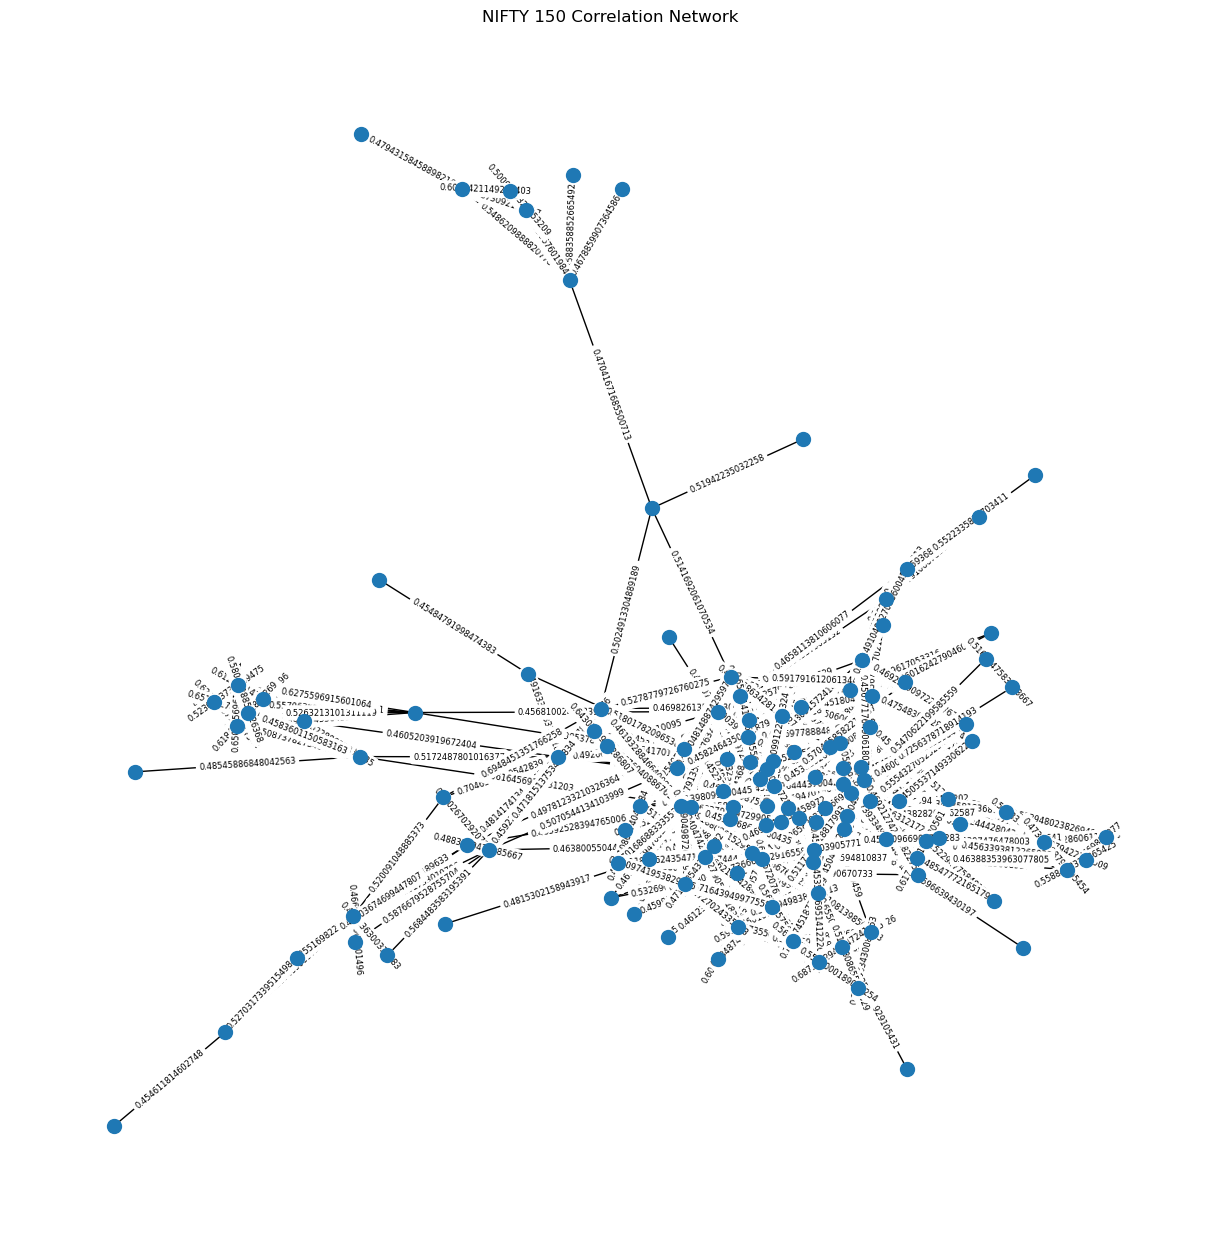

In [6]:
# Create a graph 
G = create_correlation_graph(edges, min_correlation =0.45)

print("\nNetwork Summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")

nx.write_graphml(G, "./stocks/nifty150_correlation_network.graphml")

# visualize the graph
G = nx.read_graphml("./stocks/nifty150_correlation_network.graphml")
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=100, with_labels=False, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.title("NIFTY 150 Correlation Network")

plt.show()


## Stochastic Block Model

In [7]:
class WSBMCommunityDetector:
    def __init__(self, graph_file):
        """
        Initialize with GraphML file
        """
        self.graph = nx.read_graphml(graph_file)
        # Convert weight attributes to float if they're stored as strings
        for u, v, d in self.graph.edges(data=True):
            if 'weight' in d:
                d['weight'] = float(d['weight'])
    
    def detect_communities_graphtool(self, n_blocks=None):
        """
        Detect communities using graph-tool's WSBM implementation
        """
        # Convert NetworkX graph to graph-tool format
        gt_graph = gt.Graph(directed=False)
        
        # Create edge weights property map
        edge_weights = gt_graph.new_edge_property("double")
        gt_graph.edge_properties["weight"] = edge_weights
        
        # Create vertex name property map
        vertex_names = gt_graph.new_vertex_property("string")
        gt_graph.vertex_properties["name"] = vertex_names
        
        # Create vertex mapping and add vertices
        name_to_vertex = {}
        vertex_to_name = {}  # Add reverse mapping
        for node in self.graph.nodes():
            v = gt_graph.add_vertex()
            vertex_names[v] = str(node)  # Ensure node name is string
            name_to_vertex[node] = int(v)  # Store vertex index
            vertex_to_name[int(v)] = node  # Store reverse mapping
        
        # Add edges with weights
        for u, v, data in self.graph.edges(data=True):
            e = gt_graph.add_edge(name_to_vertex[u], name_to_vertex[v])
            edge_weights[e] = data.get('weight', 1.0)
        
        if n_blocks is None:
            # Use nested block model
            state_args = dict(weight=edge_weights)
            state = gt.minimize_nested_blockmodel_dl(gt_graph, state_args=state_args)
            # Get the lowest level blocks
            blocks = state.get_bs()[0]
        else:
            # Use regular block model with specified number of blocks
            state = gt.BlockState(gt_graph, B=n_blocks, weight=edge_weights)
            # Perform MCMC moves to find optimal state
            for i in range(1000):
                state.mcmc_sweep(beta=np.inf)  # Use maximum inverse temperature
            blocks = state.get_blocks()
        
        # Convert results back to dictionary using the vertex mapping
        communities = {}
        for v in range(gt_graph.num_vertices()):
            node_name = vertex_to_name[v]
            communities[node_name] = int(blocks[v])
        
        # Relabel communities to ensure they start from 0 and are consecutive
        unique_communities = sorted(set(communities.values()))
        community_map = dict(zip(unique_communities, range(len(unique_communities))))
        communities = {k: community_map[v] for k, v in communities.items()}
        
        return communities, state
    
    def analyze_communities(self, communities):
        """Analyze the detected communities"""
        comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])
        
        # Calculate community statistics
        stats = {
            'size': comm_df['Community'].value_counts().sort_index(),
            'members': comm_df.groupby('Community').apply(lambda x: list(x.index))
        }
        
        # Calculate internal density and other metrics for each community
        densities = {}
        avg_weights = {}
        for comm in stats['size'].index:
            members = stats['members'][comm]
            subgraph = self.graph.subgraph(members)
            densities[comm] = nx.density(subgraph)
            
            # Calculate average edge weight within community
            weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
            avg_weights[comm] = np.mean(weights) if weights else 0
            
        stats['density'] = pd.Series(densities)
        stats['avg_weight'] = pd.Series(avg_weights)
        
        return stats
    
    def visualize_communities(self, communities, output_file='communities.png'):
        """Visualize the communities with improved layout and visibility"""
        plt.figure(figsize=(20, 20))
        
        # Use force-directed layout with adjusted parameters
        pos = nx.spring_layout(self.graph, k=1.5/np.sqrt(len(self.graph.nodes())), 
                             iterations=50, seed=42)
        
        # Create color map
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = dict(zip(unique_communities, colors))
        
        # Draw edges first with transparency based on weight
        edge_weights = [d['weight'] for (u, v, d) in self.graph.edges(data=True)]
        max_weight = max(edge_weights)
        
        nx.draw_networkx_edges(self.graph, pos, 
                             alpha=0.2,
                             width=[w/max_weight for w in edge_weights])
        
        # Draw nodes for each community
        for community in unique_communities:
            node_list = [node for node, comm in communities.items() if comm == community]
            nx.draw_networkx_nodes(self.graph, pos,
                                 nodelist=node_list,
                                 node_color=[color_map[community]],
                                 node_size=300,
                                 label=f'Community {community} ({len(node_list)} stocks)')
        
        # Add labels with smaller font
        nx.draw_networkx_labels(self.graph, pos, font_size=6)
        
        plt.title("Stock Communities in NIFTY 150")
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # Save with high resolution
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()

# Initialize detector with your graph file
detector = WSBMCommunityDetector("./stocks/nifty150_correlation_network.graphml")

# Detect communities
print("Detecting communities...")
communities, state = detector.detect_communities_graphtool(n_blocks=None)

# Analyze communities
print("\nAnalyzing communities...")
stats = detector.analyze_communities(communities)

# Print detailed statistics
print("\nCommunity Statistics:")
print(f"Total number of communities: {len(stats['size'])}")
print(f"Total number of stocks: {sum(stats['size'])}")
print("\nDetailed community breakdown:")
for comm in stats['size'].index:
    print(f"\nCommunity {comm}:")
    print(f"Size: {stats['size'][comm]} stocks")
    print(f"Density: {stats['density'][comm]:.3f}")
    print(f"Average correlation: {stats['avg_weight'][comm]:.3f}")
    print("Members:", ", ".join(stats['members'][comm]))

# Save communities to CSV
comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])
comm_df.to_csv('./stocks/stock_communities.csv')

# Create visualization
print("\nCreating visualization...")
detector.visualize_communities(communities, output_file='./stocks/communities_full.png')

Detecting communities...


/home/rohit/anaconda3/envs/gt/lib/python3.12/site-packages/graph_tool/inference/blockmodel.py:389: UserWarning: unrecognized keyword arguments: ['weight']
  warnings.warn("unrecognized keyword arguments: " +



Analyzing communities...

Community Statistics:
Total number of communities: 9
Total number of stocks: 129

Detailed community breakdown:

Community 0:
Size: 19 stocks
Density: 0.181
Average correlation: 0.525
Members: RELIANCE.NS, BAJFINANCE.NS, BAJAJFINSV.NS, INDIGO.NS, TITAN.NS, SRF.NS, UBL.NS, CHOLAFIN.NS, VOLTAS.NS, DEEPAKNTR.NS, TRENT.NS, APOLLOHOSP.NS, SBILIFE.NS, HDFCLIFE.NS, ICICIPRULI.NS, ICICIGI.NS, SUNTV.NS, MFSL.NS, NAVINFLUOR.NS

Community 1:
Size: 9 stocks
Density: 0.694
Average correlation: 0.574
Members: TCS.NS, INFY.NS, HCLTECH.NS, WIPRO.NS, TECHM.NS, NAUKRI.NS, MPHASIS.NS, LTTS.NS, MUTHOOTFIN.NS

Community 2:
Size: 16 stocks
Density: 0.592
Average correlation: 0.535
Members: BANKBARODA.NS, CANBK.NS, FEDERALBNK.NS, APOLLOTYRE.NS, LICHSGFIN.NS, PNB.NS, UNIONBANK.NS, SIEMENS.NS, PFC.NS, RECLTD.NS, BHARATFORG.NS, EXIDEIND.NS, HAL.NS, MANAPPURAM.NS, M&MFIN.NS, ADANIPORTS.NS

Community 3:
Size: 10 stocks
Density: 0.600
Average correlation: 0.512
Members: TVSMOTOR.NS, ASHO

/tmp/ipykernel_3821596/969496557.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'members': comm_df.groupby('Community').apply(lambda x: list(x.index))


we can see that it identifies different sectors like NIFTY TECH & IT, NIFTY ENERGY & METALS , NIFTY FINANCE & BANKS , NIFTY FMCG & PHARMA into communities. This is because the stocks in the same sector are highly correlated with each other.

/tmp/ipykernel_3821596/2882377902.py:23: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


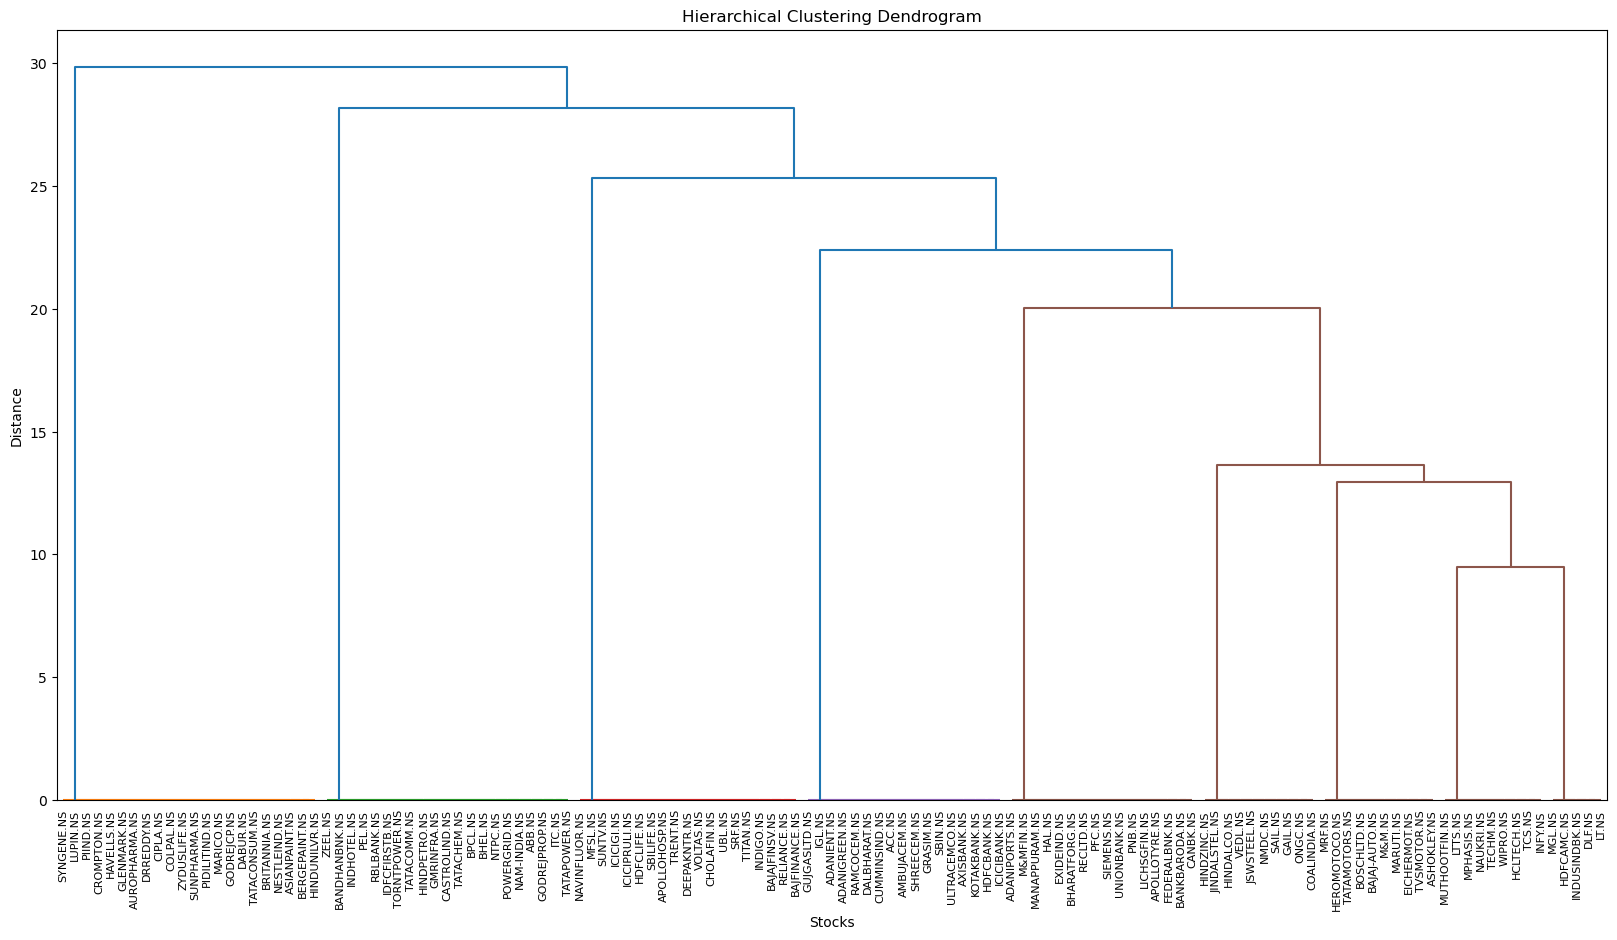

/tmp/ipykernel_3821596/2882377902.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)


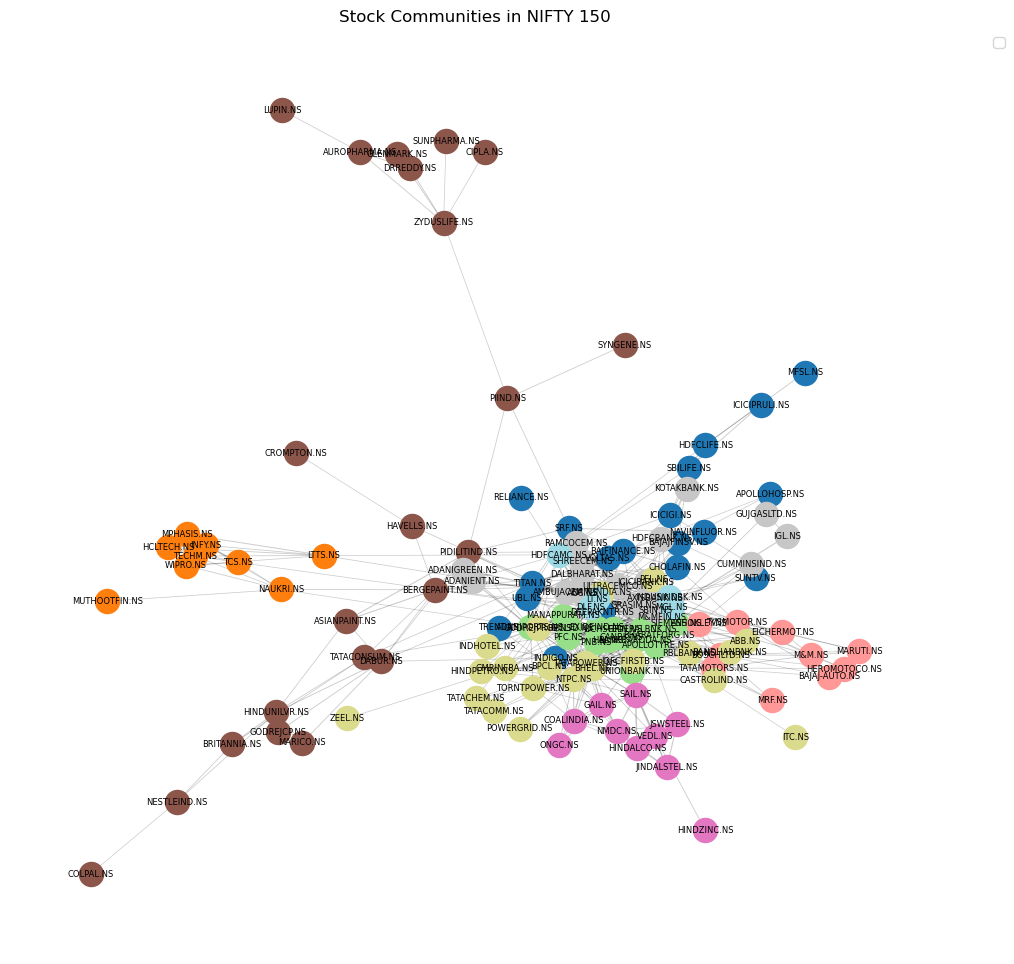

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx

# Load the stock communities data
comm_df = pd.read_csv('./stocks/stock_communities.csv', index_col=0)

# Create a distance matrix based on community assignments
stocks = comm_df.index
n = len(stocks)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if comm_df.iloc[i, 0] == comm_df.iloc[j, 0]:
            distance_matrix[i, j] = 0
        else:
            distance_matrix[i, j] = 1

# Perform hierarchical clustering
Z = linkage(distance_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, labels=stocks, orientation='top', leaf_font_size=8, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()

# Visualize graph where each member of a ciommunity has a single color
G = nx.read_graphml("./stocks/nifty150_correlation_network.graphml")
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))

# Create color map
unique_communities = sorted(set(communities.values()))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
color_map = dict(zip(unique_communities, colors))

# Draw edges first with transparency based on weight
edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
max_weight = max(edge_weights)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=[w/max_weight for w in edge_weights])

# Draw nodes for each community
for community in unique_communities:
    node_list = [node for node, comm in communities.items() if comm == community]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=[color_map[community]], node_size=300)

# Add labels with smaller font
nx.draw_networkx_labels(G, pos, font_size=6)

plt.title("Stock Communities in NIFTY 150")
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()



## Using greedy modularity based clustering


/home/rohit/anaconda3/envs/gt/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


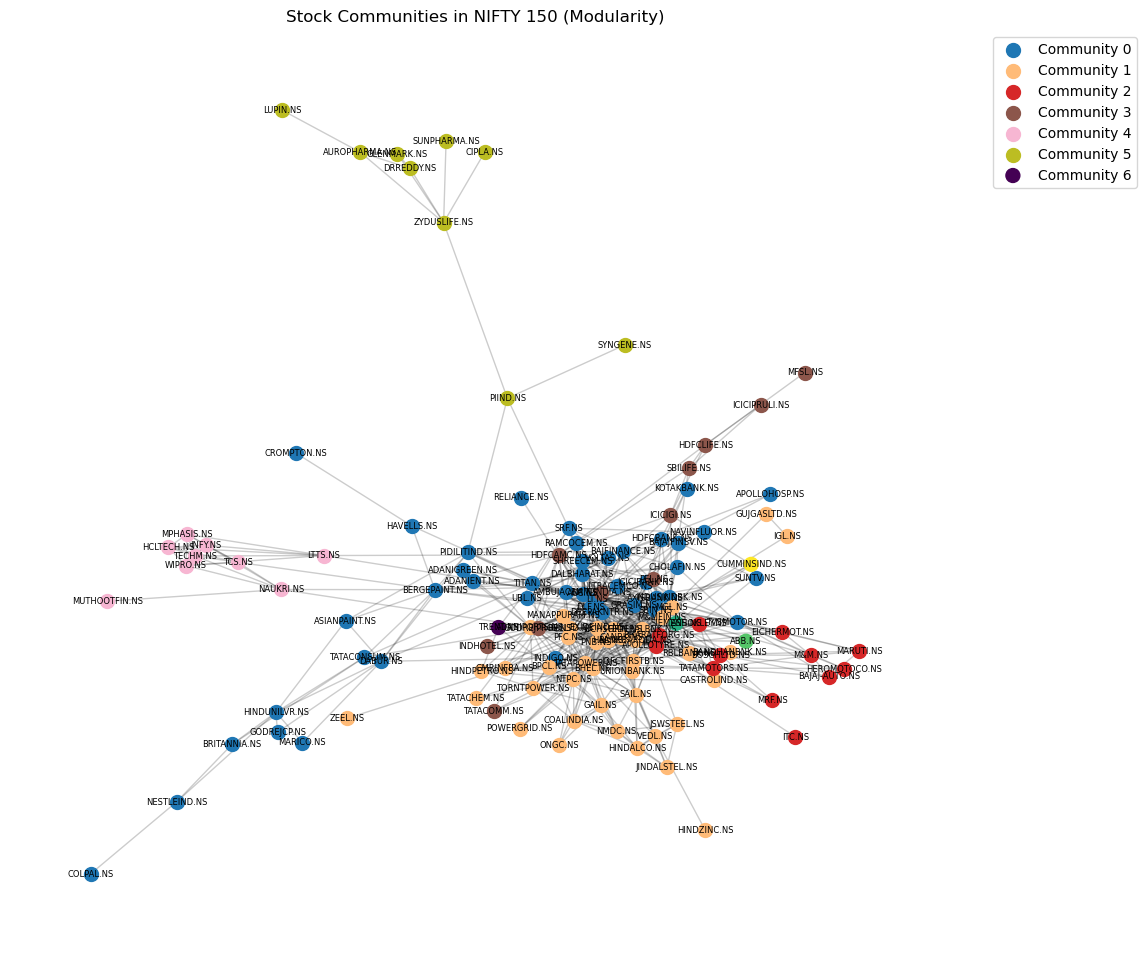


Community 0:
HAVELLS.NS, ACC.NS, AMBUJACEM.NS, BAJFINANCE.NS, MARICO.NS, TATACONSUM.NS, CROMPTON.NS, VOLTAS.NS, BRITANNIA.NS, DABUR.NS, DLF.NS, COLPAL.NS, HDFCBANK.NS, SBIN.NS, INDIGO.NS, AXISBANK.NS, CHOLAFIN.NS, KOTAKBANK.NS, TVSMOTOR.NS, DALBHARAT.NS, TITAN.NS, DEEPAKNTR.NS, INDUSINDBK.NS, SHREECEM.NS, ULTRACEMCO.NS, NAVINFLUOR.NS, NESTLEIND.NS, HINDUNILVR.NS, ADANIENT.NS, GODREJCP.NS, RAMCOCEM.NS, UBL.NS, BAJAJFINSV.NS, GRASIM.NS, SRF.NS, BERGEPAINT.NS, ADANIGREEN.NS, ASIANPAINT.NS, LT.NS, RELIANCE.NS, ICICIBANK.NS, APOLLOHOSP.NS, SUNTV.NS, PIDILITIND.NS

Community 1:
RECLTD.NS, VEDL.NS, ZEEL.NS, BPCL.NS, NTPC.NS, M&MFIN.NS, BANKBARODA.NS, COALINDIA.NS, NMDC.NS, BANDHANBNK.NS, IDFCFIRSTB.NS, LICHSGFIN.NS, PFC.NS, GMRINFRA.NS, TORNTPOWER.NS, GUJGASLTD.NS, ADANIPORTS.NS, MGL.NS, SAIL.NS, JSWSTEEL.NS, HAL.NS, EXIDEIND.NS, HINDPETRO.NS, HINDZINC.NS, POWERGRID.NS, CANBK.NS, ONGC.NS, HINDALCO.NS, CASTROLIND.NS, FEDERALBNK.NS, IGL.NS, JINDALSTEL.NS, GAIL.NS, PNB.NS, RBLBANK.NS, TATACHEM.

In [9]:
# Using greedy modularity community detection
communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')

# Convert communities to dictionary format
community_dict = {}
for idx, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = idx

# Save communities to CSV
comm_df = pd.DataFrame.from_dict(community_dict, orient='index', columns=['Community'])
comm_df.to_csv('./stocks/stock_communities_modularity.csv')

# Visualize the communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
for idx, comm in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=comm, node_color=colors[idx], node_size=100, label=f'Community {idx}')
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.title("Stock Communities in NIFTY 150 (Modularity)")
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

# print all members of eah community
for idx, comm in enumerate(communities):
    print(f"\nCommunity {idx}:")
    print(", ".join(comm))

    


## Using Girvan-Newman algorithm

Since the Girvan Newman algorithm does not use the edge weights, it does not give a good clustering of the stocks.

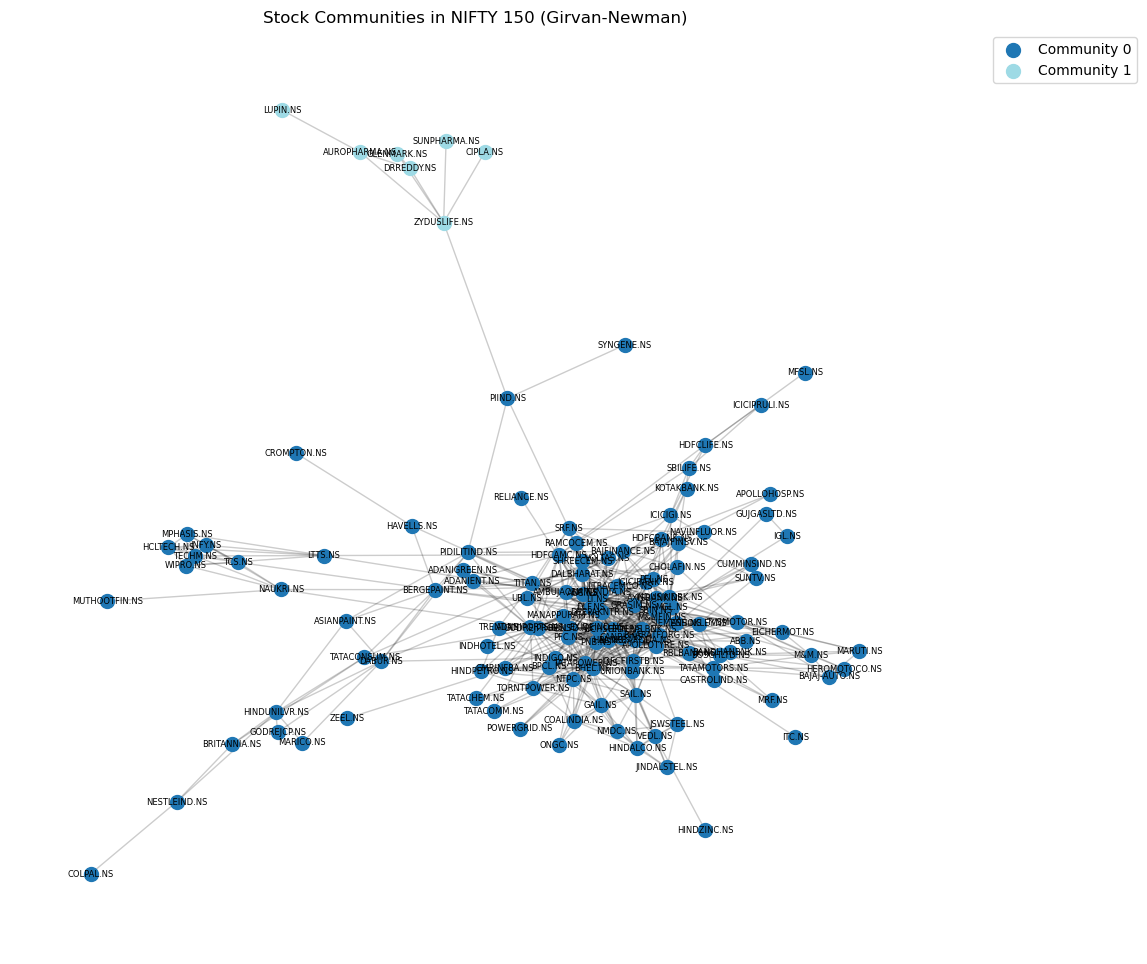


Community 0:
BPCL.NS, BANKBARODA.NS, COALINDIA.NS, NMDC.NS, CROMPTON.NS, APOLLOTYRE.NS, SBIN.NS, LICHSGFIN.NS, CHOLAFIN.NS, TRENT.NS, ASHOKLEY.NS, INDHOTEL.NS, DEEPAKNTR.NS, GUJGASLTD.NS, HAL.NS, ICICIPRULI.NS, CUMMINSIND.NS, ULTRACEMCO.NS, ABB.NS, NAVINFLUOR.NS, HINDUNILVR.NS, FEDERALBNK.NS, RAMCOCEM.NS, BAJAJFINSV.NS, LT.NS, RELIANCE.NS, BAJAJ-AUTO.NS, HDFCAMC.NS, SYNGENE.NS, MPHASIS.NS, TECHM.NS, TATAMOTORS.NS, NAM-INDIA.NS, SBILIFE.NS, HDFCBANK.NS, COLPAL.NS, AXISBANK.NS, HCLTECH.NS, WIPRO.NS, KOTAKBANK.NS, GMRINFRA.NS, TVSMOTOR.NS, SIEMENS.NS, MRF.NS, ITC.NS, JSWSTEEL.NS, CANBK.NS, ONGC.NS, HINDALCO.NS, HDFCLIFE.NS, JINDALSTEL.NS, GRASIM.NS, BERGEPAINT.NS, MUTHOOTFIN.NS, ICICIBANK.NS, SUNTV.NS, APOLLOHOSP.NS, M&M.NS, PEL.NS, MARUTI.NS, BHEL.NS, HAVELLS.NS, RECLTD.NS, ACC.NS, ICICIGI.NS, AMBUJACEM.NS, M&MFIN.NS, BAJFINANCE.NS, TATACONSUM.NS, BANDHANBNK.NS, MARICO.NS, BRITANNIA.NS, MFSL.NS, DABUR.NS, LTTS.NS, NAUKRI.NS, TITAN.NS, DALBHARAT.NS, PIIND.NS, EXIDEIND.NS, HINDZINC.NS, BH

In [10]:
# Using Girvan-Newman algorithm
communities_generator = nx.algorithms.community.girvan_newman(G)

# Convert generator to a list and select the first partition (you can choose another level if needed)
communities = next(communities_generator)

# Convert communities to dictionary format
community_dict = {}
for idx, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = idx

# Save communities to CSV
comm_df = pd.DataFrame.from_dict(community_dict, orient='index', columns=['Community'])
comm_df.to_csv('./stocks/stock_communities_girvan_newman.csv')

# Visualize the communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
for idx, comm in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_color=[colors[idx]], node_size=100, label=f'Community {idx}')
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.title("Stock Communities in NIFTY 150 (Girvan-Newman)")
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

# print all members of each community
for idx, comm in enumerate(communities):
    print(f"\nCommunity {idx}:")
    print(", ".join(comm))
    